## Creating the Notebook: "Exploring Simulation Scenarios"

This notebook provides a framework for exploring the capabilities of our anesthesia simulator through two distinct types of scenarios:

1.  **Disturbance Scenario:** This deterministic scenario is designed to evaluate the system's response to a significant and consistent external challenge. It simulates a standard patient undergoing surgery who experiences continuous stimulation at the highest intensity that the user allows. By maintaining a deterministic disturbance profile across simulations, this scenario serves as a controlled environment for the rigorous validation and design of decision-making systems and closed-loop control algorithms in the presence of a substantial and predictable process disturbance.

2.  **Closed-Loop Control Scenario:** This section provides the necessary setup and environment for users to implement and test their own closed-loop control strategies for anesthesia administration. It will include the interface to interact with the simulator in a closed-loop fashion, allowing for real-time adjustments of anesthetic agents based on simulated patient responses. This enables the evaluation of different control algorithms' efficacy and robustness in maintaining desired anesthetic levels.

**Initial Setup**

In this section, we import the necessary external libraries commonly used in scientific computing and data analysis, such as NumPy for numerical operations and Matplotlib for visualization. We also import the specific local libraries from our custom Python package that provide access to the anesthesia simulator's functionalities and models.

In [33]:
# External libraries import
import matplotlib.pyplot as plt
import numpy as np
import math

In [34]:
import os
import sys
os.chdir("/home/sara/AReS-Anesthesia-Response-Simulator/python")
# Make sure you are in Python directory
print(os.getcwd())

/home/sara/AReS-Anesthesia-Response-Simulator/python


In [35]:
# Local libraries import
from AReS import Simulator, Model, Interaction, DoHMeasure, DisturbanceType

## 1. Disturbance Scenario: Maximum Stimulation for Decision-Making System Validation

This scenario simulates a healthy patient undergoing surgery with a continuous, maximum-intensity surgical stimulation. Importantly, this scenario is deterministic, meaning the disturbance profile remains consistent across multiple simulations. This deliberate design choice allows users to utilize this specific scenario as a predefined and reproducible testbed for the rigorous validation and design of their decision-making systems under consistent, high-level process disturbance. By keeping the disturbance profile constant, researchers can reliably assess the performance and robustness of their automated control strategies in the presence of a significant and predictable challenge.

**Disturbance Setup**

The `stimuli` dictionary defines a sequence of simulated surgical events or disturbances that will occur during the anesthesia procedure. The keys of the dictionary represent the start time of each disturbance in seconds from the beginning of the simulation. The value associated with each start time is a tuple containing the following information:

* **Disturbance Type:** The type of surgical event or disturbance being simulated (e.g., intubation, incision, skin manipulation, and suture).
* **Duration:** The duration of the disturbance in seconds.
* **Maximum Intensity:** A list of three numerical values representing the maximum intensity of the disturbance's effect on three key physiological variables:
    * The first element corresponds to the maximum intensity affecting the Depth of Hypnosis (DoH).
    * The second element corresponds to the maximum intensity affecting the Heart Rate (HR).
    * The third element corresponds to the maximum intensity affecting the Mean Arterial Pressure (MAP).

Here's a breakdown of the specific disturbances defined in the `stimuli` dictionary:

* At **1 minute (60 seconds)**, an **INTUBATION** disturbance will begin and last for **2 minutes (120 seconds)**. The maximum intensity of this disturbance is `[10, 10, 20]` for DoH, HR, and MAP, respectively.
* At **5 minutes (300 seconds)**, an **INCISION** disturbance will begin and last for **2 minutes (120 seconds)**. The maximum intensity is `[10, 10, 20]` for DoH, HR, and MAP.
* At **10 minutes (600 seconds)**, a **SKIN_MANIPULATION** disturbance will begin and last for **10 minutes (600 seconds)**. The maximum intensity is `[5, 5, 10]` for DoH, HR, and MAP.
* At **21 minutes (1260 seconds)**, a **SUTURE** disturbance will begin and last for **5 minutes (300 seconds)**. The maximum intensity is `[2, 2, 4]` for DoH, HR, and MAP.

In [36]:
stimuli = {
    1 * 60: (DisturbanceType.INTUBATION, 2 * 60, [10, 10, 20]), 
    5 * 60: (DisturbanceType.INCISION, 2 * 60, [10, 10, 20]),  
    10 * 60: (DisturbanceType.SKIN_MANIPULATION, 10 * 60, [5, 5,10]),
    21 * 60: (DisturbanceType.SUTURE, 5 * 60, [2, 2, 4]) 
}
print(stimuli)

{60: (<DisturbanceType.INTUBATION: 1>, 120, [10, 10, 20]), 300: (<DisturbanceType.INCISION: 2>, 120, [10, 10, 20]), 600: (<DisturbanceType.SKIN_MANIPULATION: 3>, 600, [5, 5, 10]), 1260: (<DisturbanceType.SUTURE: 4>, 300, [2, 2, 4])}


**Simulation Setup:**
The following code cell initializes the anesthesia simulator with specific configurations for the simulation run. Let's break down each parameter:

* **`simulator = Simulator.create()`**: This line creates an instance of the `Simulator` object. This is the core object that will manage the simulation environment, including patient models, drug models, and the progression of time.

* **`interaction = Interaction.SURFACE`**: This parameter defines how the interaction between the two anesthetic drugs, propofol ('prop') and remifentanil ('remi'), will be modeled. Here, `Interaction.SURFACE` indicates that a surface model will be implemented.

* **`doh_measure = DoHMeasure.BOTH`**: This parameter specifies which physiological signal will be used as the measure of the Depth of Hypnosis (DoH). In this case, `DoHMeasure.BOTH` indicates that the simulator will track and report both the BIS and WAV signals.

* **`t_sim = 30 * 60`**: This parameter sets the total duration of the simulation. The value is given in seconds, so `30 * 60` equates to a simulation lasting for 30 minutes.

* **`t_s = 5`**: This parameter defines the sampling interval for the simulation and potential control actions. A value of `5` indicates that the simulator will update its state and potentially apply control inputs every 5 seconds. This parameter is crucial for discrete-time control system implementations.

* **`pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}`**: This dictionary specifies the pharmacokinetic (PK) models to be used for propofol and remifentanil. Note that only one choice of pk model exists for other two drugs (norepinephrine and rocuronium). Here, the `Model.ELEVELD` model is selected for both propofol ('prop') and remifentanil ('remi').

* **`pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}`**: This dictionary specifies the pharmacodynamic (PD) models to be used for each drug. These PD models describe the relationship between the drug concentration at the effect site and the changes in DoH. Here, a `Model.PATIENT_SPECIFIC` PD model will be used for propofol and for remifentanil, the population-based `Model.ELEVELD` PD model will be used.

In [37]:
simulator = Simulator.create()
interaction = Interaction.SURFACE
doh_measure = DoHMeasure.BOTH
t_sim = 30 * 60
t_s = 5
pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}

Next, we define the infusion rates for the four drugs considered in this simulation: propofol, remifentanil, norepinephrine, and rocuronium. In this specific implementation, the infusion rate for each drug remains constant throughout the entire simulation. However, users have the flexibility to define time-varying infusion profiles for any or all of these drugs according to their experimental needs.

In [38]:
u_prop = [0.2] * t_sim
u_remi = [0.2] * t_sim
u_nore = [0.01] * t_sim
u_rocu = [0.1] * t_sim

In [30]:
patient_id = 2
simulator.init_simulation_from_file(id_patient=patient_id, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                        pd_models=pd_models, interaction=interaction, doh_measure=doh_measure,worst_case=True,stimuli=stimuli)
simulator.run_complete_simulation(u_prop, u_remi, u_nore, u_rocu)
simulator.save_simulation()

results = simulator.get_patient_results()

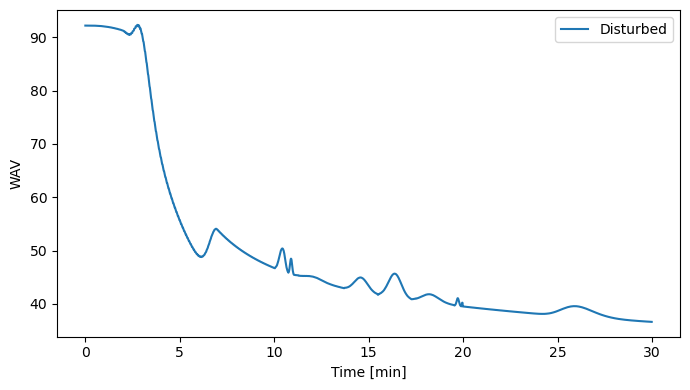

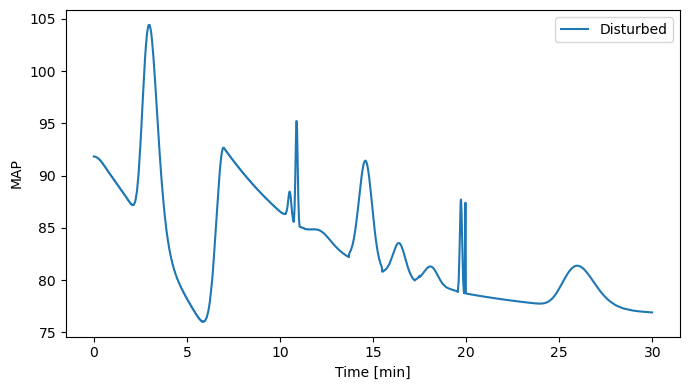

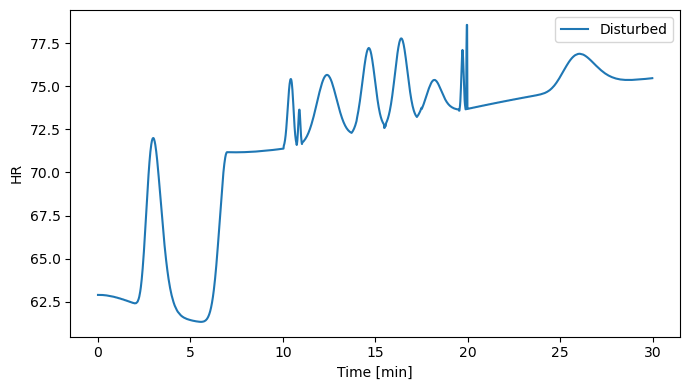

In [31]:
num_samples = len(results['_BIS_all'][0])
t = np.arange(num_samples) / 60
names = {'_WAV_all': 'WAV', '_MAP_all': 'MAP', '_HR_all': 'HR'}


for key in names.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t,results[key][0], label='Disturbed')
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(names[key])
    ax.legend()
    plt.tight_layout()
    plt.show()

## Closed-Loop Control Scenario

Here, we demonstrate a step-wise simulation with the disturbance profile defined in the previous section, and show how the user can incorporate the feedback signal. The following code block simulates a closed-loop control scenario for propofol administration using the AReS simulator. Here's a step-by-step explanation:
1. **Initialization:**  The simulator is initialized similarly to the previous scenario; however, for simplicity, we assume no external stimuli or disturbances are applied in this particular simulation run

2.  **`reference_signal = 30`**: This line sets the target or reference value for the controlled variable, which is likely the WAV index (a measure of the Depth of Hypnosis).

3.  **`k_p = 0.006`**: This line defines the proportional gain (`k_p`) for a simple proportional controller. This gain determines how strongly the control output (propofol infusion rate) responds to the error between the measured WAV value and the reference signal.

6.  **`u_prop_controlled = 2`**: This line initializes the control input for propofol (`u_prop_controlled`) to a starting value of 2 (likely representing an initial infusion rate in some units). This value will be updated by the controller in subsequent steps.

7.  **`for time in range(t_sim // t_s):`**: This loop iterates through the simulation time, with each iteration representing one control time step (`t_s`). `t_sim // t_s` calculates the total number of control steps in the simulation.

8.  **`simulator.one_step_simulation(u_prop_controlled, 0, 0, 0)`**: This is the core simulation step. It advances the simulation by one time step (`t_s`). The arguments represent the control inputs for the four drugs (in order: propofol, remifentanil, norepinephrine, rocuronium). Here, the propofol infusion rate is determined by `u_prop_controlled`, while the infusion rates for the other three drugs are set to 0, indicating they are not being actively controlled or administered in this specific closed-loop scenario.

9.  **`states = simulator.get_patient_state()`**: This line retrieves the current physiological state of the simulated patient after the one-step simulation. This `states` variable likely contains various physiological parameters, including the WAV index.

10. **`wav_value = states['WAV']`**: This line extracts the current value of the WAV index from the `states` dictionary. This value will be used as the feedback signal for the controller.

11. **`u_prop_controlled = np.clip(k_p*(wav_value - reference_signal), 0, 2)`**: This line implements the proportional control law:
    * `wav_value - reference_signal`: Calculates the error between the current WAV value and the desired reference signal.
    * `k_p * (...)`: Multiplies the error by the proportional gain (`k_p`) to determine the control action.
    * `np.clip(..., 0, 2)`: This function limits the propofol infusion rate (`u_prop_controlled`) to be within the range of 0 to 2 (likely representing the physical limitations or safe operating range of the infusion pump). The updated `u_prop_controlled` value will be used in the next simulation step.

12. **`# print(u_prop_controlled)`**: This line is commented out, but it would have printed the calculated propofol infusion rate at each time step, which could be useful for monitoring the controller's behavior.

13. **`simulator.save_simulation()`**: After the simulation loop completes, this line saves the recorded simulation data (time series of physiological states and drug concentrations) for later analysis.

In summary, this code simulates a closed-loop control system aiming to maintain the patient's WAV index at a target value of 30 by adjusting the propofol infusion rate using a simple proportional controller. The simulation runs for 30 minutes with a 5-second control interval, and the patient's response is based on a specific patient profile loaded at the beginning. No external disturbances or control of other drugs are included in this particular scenario.

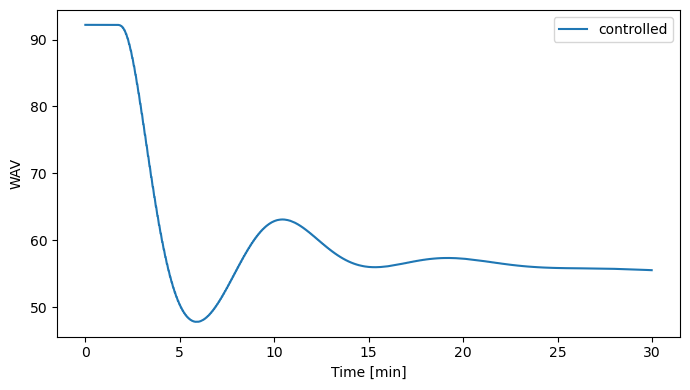

In [95]:
simulator.reset()

patient_id = 2
simulator.init_simulation_from_file(id_patient=patient_id, t_sim=t_sim, t_s=t_s, pk_models=pk_models,
                                        pd_models=pd_models, interaction=interaction, doh_measure=doh_measure,worst_case=True,stimuli=None)
reference_signal = 30
k_p = 0.006
u_prop_controlled = 2
for time in range(t_sim // t_s):
    simulator.one_step_simulation(u_prop_controlled, 0, 0, 0)
    states = simulator.get_patient_state()
    wav_value = states['WAV']
    u_prop_controlled = np.clip(k_p*(wav_value - reference_signal), 0, 2)
    # print(u_prop_controlled)
simulator.save_simulation()

results = simulator.get_patient_results()
num_samples = len(results['_WAV_all'][0])
t = np.arange(num_samples) / 60
names = {'_WAV_all': 'WAV'}


for key in names.keys():
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(t,results[key][0], label='controlled')
    ax.set_xlabel('Time [min]')
    ax.set_ylabel(names[key])
    ax.legend()
    plt.tight_layout()
    plt.show()

